**Module Paths**

In [1]:
import os

os.chdir("./../..")

**Device**

In [2]:
from utils.device import get_device

device = get_device()
device

device(type='mps')

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='../assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='../assets/leaky_relu.png' width=40% />

#### Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

#### Structure

The discriminator takes a high dimensional input (for example, an image) and outputs a single score value. Linear layers in the discriminator should have a number of neurons such that the dimensions of their output is smaller than the dimension of their input.

In [3]:
import torch
import torch.nn as nn

In [4]:
class Discriminator(nn.Module):
    """
    Discriminator model:
    args:
    - input_dim: dimension of the input data. For example, for a 28 by 28 grayscale image, the input size is 784
    - hidden_dim: a parameter that controls the dimensions of the hidden layers.
    """

    def __init__(self, input_dim: int, hidden_dim: int):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='../assets/tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_size: int):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.leaky_relu(x)

        x = self.fc2(x)
        x = self.tanh(x)
        return x

# Tips for Training GANs

### Good Architecture

**Fully Connected Architecture** can be used for simple tasks that meet the following criteria:

1. No convolution
2. No recurrence
3. The generator and discriminator have at least one hidden layer

**Leaky ReLU** helps to ensure that the gradient can flow through the entire architecture and is a popular choice for hidden layer activation functions.

The **Hyperbolic Tangent** activation function is a popular output choice for the generator and means data should be scaled to the interval from -1 to +1.

A **Sigmoid Unit** is used to enforce the constraint that the output of the discriminator is a probability.

### Design Choice

One of the design choices from the DCGAN architecture is **Adam**, an optimization algorithm.

A common error is that people forget to use a numerically stable version of **cross-entropy**, where the loss is computed using the **logits**.

- **Logits** – the values produced by the discriminator right before the **sigmoid**.

### Tips for Training

1. A simple trick is to multiply the 0 or 1 labels by a number a bit less than 1. This is a GANs-specific label smoothing strategy similar to that used to regularize normal classifiers.
2. For the generator loss, minimize cross-entropy with the labels flipped.

### Scaling GANs

**Convolutional Neural Networks (CNN)** are needed to scale GANs to work on larger images. Scaling GANs relies on an understanding of:

- **Classifier Convolutional Net** – starting with a tall and wide feature map and moving to very short and narrow feature maps
- **Generator Net** – starting with short and narrow feature maps and moving to a wide and tall image
- **Batch Normalization** – applied to potentially every layer except the output layer of the generator and the input layer of the discriminator

## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='../assets/gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels by a factor of 0.9
. 

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 



In [6]:
# Calculate losses
def real_loss(D_out, smooth=False):
    ####
    target = torch.ones_like(D_out)
    if smooth:
        target *= 0.9

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, target)
    ####
    return loss

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [7]:
def fake_loss(D_out):
    target = torch.zeros_like(D_out)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, target)
    return loss

## Load the Data

In [8]:
from torchvision import transforms as T

train_transform = T.Compose([T.ToTensor()])

In [9]:
from data import DatasetWrapper

dataset_wrapper = DatasetWrapper(
    dataset_name="MNIST",
    root="./gan/mnist/data",
    train_transform=train_transform,
    download=True,
    train_ratio=1,
)

## Create DataLoader

In [10]:
batch_size = 128

from data import DataLoaderWrapper

train_dataset, _, _ = dataset_wrapper.get_datasets()

train_loader_wrapper = DataLoaderWrapper(
    dataset=train_dataset, batch_size=batch_size, num_workers=4
)

train_loader = train_loader_wrapper.get_loader()

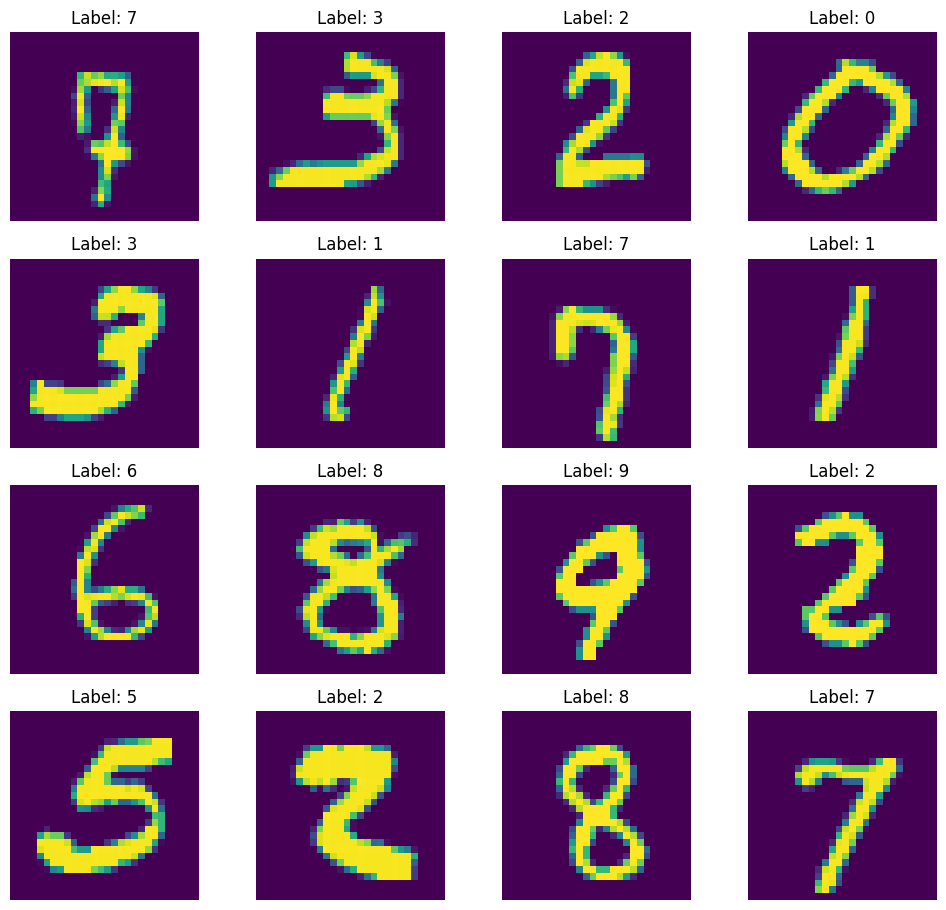

In [11]:
train_loader_wrapper.display_sample_images()

# Model hyperparameters

In [12]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of last hidden layer in the discriminator
d_hidden_size = 128

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

# Hyperparameters
g_lr = 0.0002
d_lr = 0.0002
beta1 = 0.5
beta2 = 0.999
label_noise = 0.0
instance_noise = 0.0
g_updates = 2
smooth = False
num_epochs = 25
criterion_name = "bce"

## Initialize model, criterion, optimizer

In [13]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
  (tanh): Tanh()
)


In [14]:
from optimize import OptimizerWrapper

# Create optimizers for the discriminator and generator
d_optimizer = OptimizerWrapper(D, "adam", lr=d_lr, betas=(beta1, beta2)).get_optimizer()
g_optimizer = OptimizerWrapper(G, "adam", lr=g_lr, betas=(beta1, beta2)).get_optimizer()

## Train the model

In [15]:
from trainer import GANTrainer

trainer = GANTrainer(
    G,
    D,
    train_loader,
    g_optimizer,
    d_optimizer,
    z_size,
    device=device,
    criterion_name=criterion_name,
)

2024-11-05 13:31:54 | Batch 0/469 | d_loss: 1.3894 | g_loss: 0.6554 | D(x): 0.5224 | D(G(z)): 0.5229/0.5193
2024-11-05 13:31:55 | Batch 100/469 | d_loss: 1.0465 | g_loss: 0.7626 | D(x): 0.6859 | D(G(z)): 0.4838/0.4677
2024-11-05 13:31:56 | Batch 200/469 | d_loss: 0.6484 | g_loss: 1.3473 | D(x): 0.7150 | D(G(z)): 0.2581/0.2643
2024-11-05 13:31:57 | Batch 300/469 | d_loss: 0.4338 | g_loss: 1.7149 | D(x): 0.8136 | D(G(z)): 0.1895/0.1896
2024-11-05 13:31:58 | Batch 400/469 | d_loss: 0.4352 | g_loss: 1.6020 | D(x): 0.8404 | D(G(z)): 0.2085/0.2141


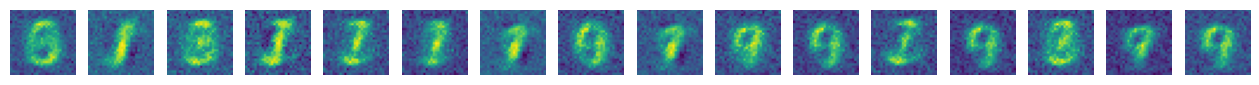

2024-11-05 13:32:00 | Batch 0/469 | d_loss: 0.4440 | g_loss: 1.7662 | D(x): 0.8213 | D(G(z)): 0.1896/0.1767
2024-11-05 13:32:01 | Batch 100/469 | d_loss: 0.4696 | g_loss: 1.8550 | D(x): 0.8161 | D(G(z)): 0.2013/0.1675
2024-11-05 13:32:02 | Batch 200/469 | d_loss: 0.2921 | g_loss: 2.4031 | D(x): 0.8775 | D(G(z)): 0.1252/0.0978
2024-11-05 13:32:03 | Batch 300/469 | d_loss: 0.3243 | g_loss: 2.6646 | D(x): 0.8873 | D(G(z)): 0.1577/0.0793
2024-11-05 13:32:04 | Batch 400/469 | d_loss: 0.2216 | g_loss: 3.1085 | D(x): 0.8968 | D(G(z)): 0.0678/0.0532


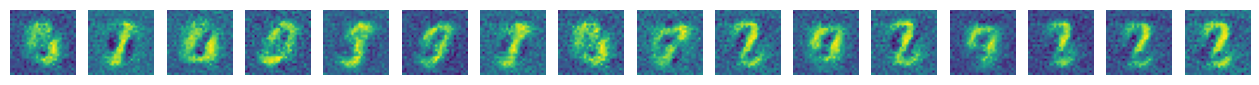

2024-11-05 13:32:06 | Batch 0/469 | d_loss: 0.3559 | g_loss: 2.8174 | D(x): 0.8561 | D(G(z)): 0.1099/0.0757
2024-11-05 13:32:07 | Batch 100/469 | d_loss: 0.2710 | g_loss: 2.6855 | D(x): 0.8916 | D(G(z)): 0.1184/0.0825
2024-11-05 13:32:08 | Batch 200/469 | d_loss: 0.2802 | g_loss: 2.9177 | D(x): 0.8592 | D(G(z)): 0.0537/0.0666
2024-11-05 13:32:09 | Batch 300/469 | d_loss: 0.3426 | g_loss: 2.3469 | D(x): 0.8632 | D(G(z)): 0.1310/0.1319
2024-11-05 13:32:09 | Batch 400/469 | d_loss: 0.2372 | g_loss: 2.7449 | D(x): 0.9197 | D(G(z)): 0.1172/0.0857


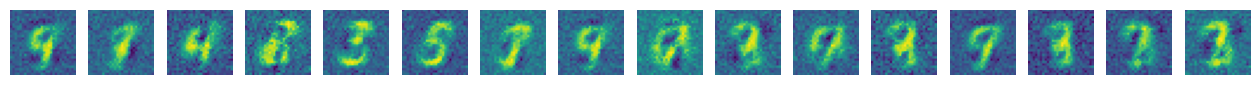

2024-11-05 13:32:12 | Batch 0/469 | d_loss: 0.3183 | g_loss: 3.1728 | D(x): 0.9161 | D(G(z)): 0.1571/0.0645
2024-11-05 13:32:13 | Batch 100/469 | d_loss: 0.2285 | g_loss: 2.8666 | D(x): 0.9197 | D(G(z)): 0.1032/0.0920
2024-11-05 13:32:14 | Batch 200/469 | d_loss: 0.2948 | g_loss: 2.9560 | D(x): 0.8738 | D(G(z)): 0.0680/0.0772
2024-11-05 13:32:14 | Batch 300/469 | d_loss: 0.2713 | g_loss: 3.0184 | D(x): 0.8801 | D(G(z)): 0.0765/0.0698
2024-11-05 13:32:15 | Batch 400/469 | d_loss: 0.2319 | g_loss: 3.5708 | D(x): 0.9167 | D(G(z)): 0.0965/0.0475


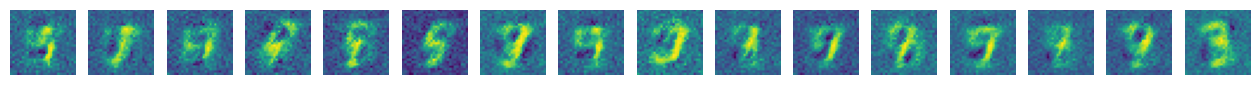

2024-11-05 13:32:18 | Batch 0/469 | d_loss: 0.3078 | g_loss: 2.8942 | D(x): 0.8788 | D(G(z)): 0.1001/0.0819
2024-11-05 13:32:19 | Batch 100/469 | d_loss: 0.2682 | g_loss: 2.9314 | D(x): 0.8910 | D(G(z)): 0.0818/0.0801
2024-11-05 13:32:20 | Batch 200/469 | d_loss: 0.2491 | g_loss: 3.1576 | D(x): 0.9054 | D(G(z)): 0.0582/0.0674
2024-11-05 13:32:21 | Batch 300/469 | d_loss: 0.2351 | g_loss: 3.2303 | D(x): 0.9336 | D(G(z)): 0.0705/0.0624
2024-11-05 13:32:22 | Batch 400/469 | d_loss: 0.2556 | g_loss: 3.9114 | D(x): 0.9352 | D(G(z)): 0.1165/0.0402


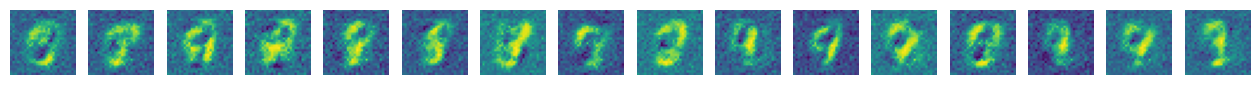

2024-11-05 13:32:25 | Batch 0/469 | d_loss: 0.2160 | g_loss: 3.3501 | D(x): 0.9417 | D(G(z)): 0.0973/0.0693
2024-11-05 13:32:26 | Batch 100/469 | d_loss: 0.2184 | g_loss: 3.4607 | D(x): 0.9116 | D(G(z)): 0.0751/0.0574
2024-11-05 13:32:27 | Batch 200/469 | d_loss: 0.2083 | g_loss: 3.9392 | D(x): 0.9213 | D(G(z)): 0.0571/0.0533
2024-11-05 13:32:28 | Batch 300/469 | d_loss: 0.2293 | g_loss: 3.2563 | D(x): 0.9268 | D(G(z)): 0.0860/0.0767
2024-11-05 13:32:29 | Batch 400/469 | d_loss: 0.2515 | g_loss: 4.0795 | D(x): 0.9144 | D(G(z)): 0.0736/0.0293


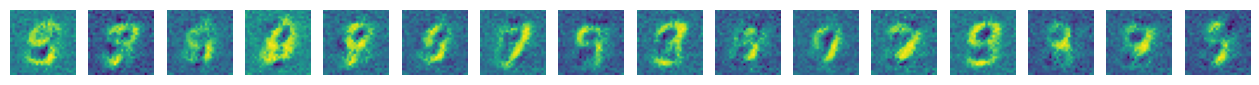

2024-11-05 13:32:31 | Batch 0/469 | d_loss: 0.1503 | g_loss: 4.5704 | D(x): 0.9569 | D(G(z)): 0.0828/0.0217
2024-11-05 13:32:32 | Batch 100/469 | d_loss: 0.2279 | g_loss: 3.4450 | D(x): 0.9358 | D(G(z)): 0.1020/0.0701
2024-11-05 13:32:33 | Batch 200/469 | d_loss: 0.3032 | g_loss: 3.4339 | D(x): 0.9048 | D(G(z)): 0.0525/0.0690
2024-11-05 13:32:34 | Batch 300/469 | d_loss: 0.3295 | g_loss: 3.0640 | D(x): 0.8576 | D(G(z)): 0.0200/0.1256
2024-11-05 13:32:35 | Batch 400/469 | d_loss: 0.1710 | g_loss: 4.3063 | D(x): 0.9501 | D(G(z)): 0.0734/0.0356


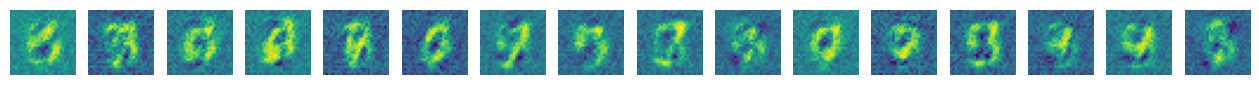

2024-11-05 13:32:37 | Batch 0/469 | d_loss: 0.1460 | g_loss: 4.2996 | D(x): 0.9499 | D(G(z)): 0.0354/0.0316
2024-11-05 13:32:38 | Batch 100/469 | d_loss: 0.2265 | g_loss: 4.8809 | D(x): 0.9493 | D(G(z)): 0.1205/0.0216
2024-11-05 13:32:39 | Batch 200/469 | d_loss: 0.1638 | g_loss: 4.5180 | D(x): 0.9422 | D(G(z)): 0.0602/0.0311
2024-11-05 13:32:40 | Batch 300/469 | d_loss: 0.1144 | g_loss: 4.9637 | D(x): 0.9802 | D(G(z)): 0.0737/0.0230
2024-11-05 13:32:40 | Batch 400/469 | d_loss: 0.1508 | g_loss: 4.0648 | D(x): 0.9564 | D(G(z)): 0.0520/0.0631


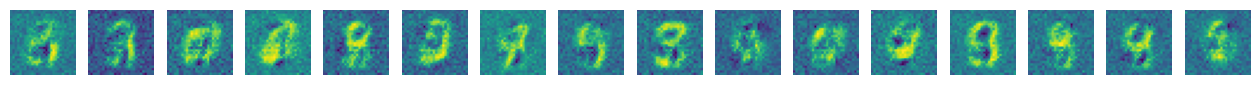

2024-11-05 13:32:43 | Batch 0/469 | d_loss: 0.1544 | g_loss: 3.9236 | D(x): 0.9354 | D(G(z)): 0.0430/0.0521
2024-11-05 13:32:44 | Batch 100/469 | d_loss: 0.2354 | g_loss: 4.2289 | D(x): 0.9155 | D(G(z)): 0.0444/0.0411
2024-11-05 13:32:45 | Batch 200/469 | d_loss: 0.1081 | g_loss: 5.0598 | D(x): 0.9697 | D(G(z)): 0.0376/0.0175
2024-11-05 13:32:45 | Batch 300/469 | d_loss: 0.1855 | g_loss: 5.0661 | D(x): 0.9445 | D(G(z)): 0.0626/0.0180
2024-11-05 13:32:46 | Batch 400/469 | d_loss: 0.1979 | g_loss: 4.3127 | D(x): 0.9484 | D(G(z)): 0.0409/0.0426


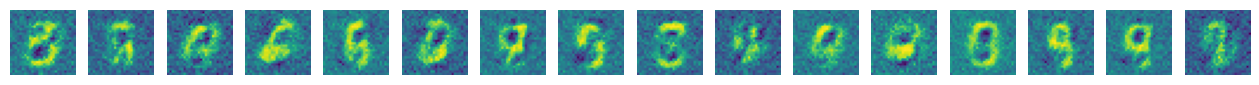

2024-11-05 13:32:49 | Batch 0/469 | d_loss: 0.1768 | g_loss: 4.6933 | D(x): 0.9261 | D(G(z)): 0.0216/0.0293
2024-11-05 13:32:49 | Batch 100/469 | d_loss: 0.1355 | g_loss: 4.6346 | D(x): 0.9559 | D(G(z)): 0.0369/0.0339
2024-11-05 13:32:50 | Batch 200/469 | d_loss: 0.1358 | g_loss: 4.9053 | D(x): 0.9719 | D(G(z)): 0.0667/0.0227
2024-11-05 13:32:51 | Batch 300/469 | d_loss: 0.2540 | g_loss: 4.5557 | D(x): 0.9405 | D(G(z)): 0.0355/0.0488
2024-11-05 13:32:52 | Batch 400/469 | d_loss: 0.0924 | g_loss: 5.4984 | D(x): 0.9734 | D(G(z)): 0.0434/0.0171


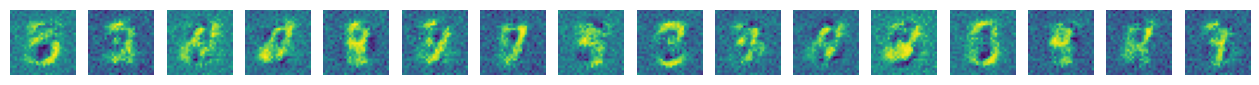

2024-11-05 13:32:54 | Batch 0/469 | d_loss: 0.0962 | g_loss: 5.7569 | D(x): 0.9817 | D(G(z)): 0.0506/0.0249
2024-11-05 13:32:55 | Batch 100/469 | d_loss: 0.2130 | g_loss: 5.4482 | D(x): 0.9456 | D(G(z)): 0.0726/0.0302
2024-11-05 13:32:56 | Batch 200/469 | d_loss: 0.2278 | g_loss: 4.8282 | D(x): 0.9601 | D(G(z)): 0.1021/0.0265
2024-11-05 13:32:57 | Batch 300/469 | d_loss: 0.1590 | g_loss: 6.4735 | D(x): 0.9515 | D(G(z)): 0.0522/0.0123
2024-11-05 13:32:58 | Batch 400/469 | d_loss: 0.1135 | g_loss: 4.7284 | D(x): 0.9503 | D(G(z)): 0.0154/0.0329


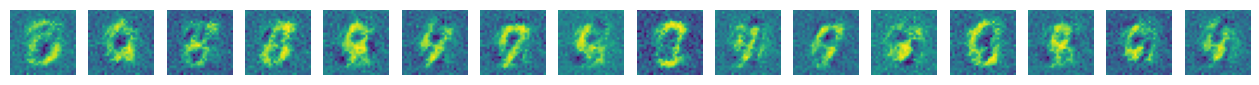

2024-11-05 13:33:00 | Batch 0/469 | d_loss: 0.1218 | g_loss: 5.6479 | D(x): 0.9694 | D(G(z)): 0.0647/0.0207
2024-11-05 13:33:01 | Batch 100/469 | d_loss: 0.0685 | g_loss: 5.9139 | D(x): 0.9888 | D(G(z)): 0.0477/0.0194
2024-11-05 13:33:02 | Batch 200/469 | d_loss: 0.1654 | g_loss: 5.2215 | D(x): 0.9425 | D(G(z)): 0.0413/0.0254
2024-11-05 13:33:02 | Batch 300/469 | d_loss: 0.1768 | g_loss: 4.7407 | D(x): 0.9470 | D(G(z)): 0.0604/0.0316
2024-11-05 13:33:03 | Batch 400/469 | d_loss: 0.2115 | g_loss: 6.4162 | D(x): 0.9719 | D(G(z)): 0.1135/0.0128


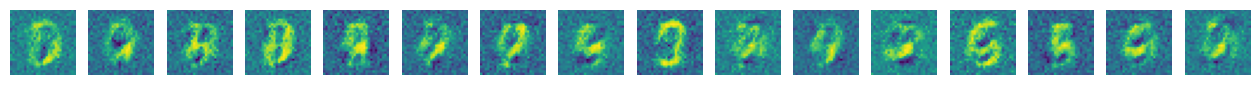

2024-11-05 13:33:06 | Batch 0/469 | d_loss: 0.1352 | g_loss: 5.8514 | D(x): 0.9690 | D(G(z)): 0.0623/0.0154
2024-11-05 13:33:07 | Batch 100/469 | d_loss: 0.1131 | g_loss: 4.9299 | D(x): 0.9458 | D(G(z)): 0.0171/0.0514
2024-11-05 13:33:08 | Batch 200/469 | d_loss: 0.1624 | g_loss: 5.8635 | D(x): 0.9416 | D(G(z)): 0.0374/0.0218
2024-11-05 13:33:08 | Batch 300/469 | d_loss: 0.1108 | g_loss: 5.2606 | D(x): 0.9880 | D(G(z)): 0.0809/0.0203
2024-11-05 13:33:09 | Batch 400/469 | d_loss: 0.1897 | g_loss: 5.5111 | D(x): 0.9506 | D(G(z)): 0.0204/0.0226


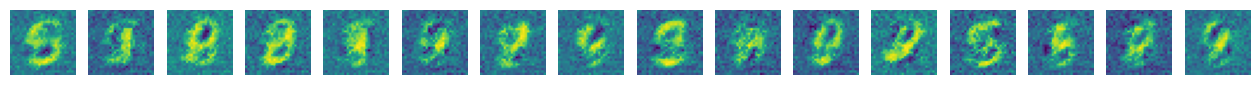

2024-11-05 13:33:12 | Batch 0/469 | d_loss: 0.0691 | g_loss: 5.6796 | D(x): 0.9721 | D(G(z)): 0.0224/0.0193
2024-11-05 13:33:12 | Batch 100/469 | d_loss: 0.1680 | g_loss: 5.1331 | D(x): 0.9563 | D(G(z)): 0.0408/0.0221
2024-11-05 13:33:13 | Batch 200/469 | d_loss: 0.0920 | g_loss: 5.6192 | D(x): 0.9727 | D(G(z)): 0.0495/0.0287
2024-11-05 13:33:14 | Batch 300/469 | d_loss: 0.0698 | g_loss: 5.2286 | D(x): 0.9645 | D(G(z)): 0.0221/0.0435
2024-11-05 13:33:15 | Batch 400/469 | d_loss: 0.1799 | g_loss: 6.2861 | D(x): 0.9600 | D(G(z)): 0.0624/0.0103


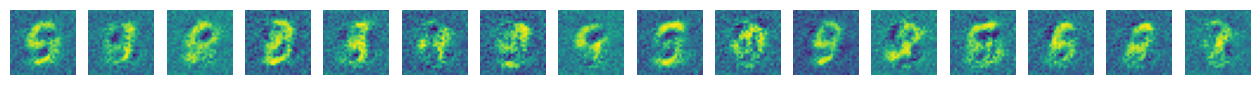

2024-11-05 13:33:17 | Batch 0/469 | d_loss: 0.2152 | g_loss: 6.0348 | D(x): 0.9800 | D(G(z)): 0.1143/0.0134
2024-11-05 13:33:18 | Batch 100/469 | d_loss: 0.0758 | g_loss: 5.7625 | D(x): 0.9670 | D(G(z)): 0.0263/0.0161
2024-11-05 13:33:19 | Batch 200/469 | d_loss: 0.1184 | g_loss: 5.2284 | D(x): 0.9438 | D(G(z)): 0.0116/0.0238
2024-11-05 13:33:20 | Batch 300/469 | d_loss: 0.1030 | g_loss: 6.2847 | D(x): 0.9785 | D(G(z)): 0.0533/0.0129
2024-11-05 13:33:21 | Batch 400/469 | d_loss: 0.1491 | g_loss: 5.7819 | D(x): 0.9527 | D(G(z)): 0.0475/0.0247


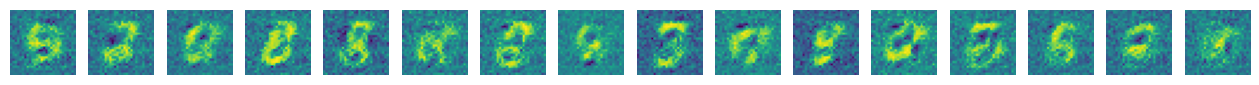

2024-11-05 13:33:23 | Batch 0/469 | d_loss: 0.0659 | g_loss: 5.3902 | D(x): 0.9857 | D(G(z)): 0.0148/0.0257
2024-11-05 13:33:24 | Batch 100/469 | d_loss: 0.1383 | g_loss: 4.4983 | D(x): 0.9577 | D(G(z)): 0.0337/0.0476
2024-11-05 13:33:25 | Batch 200/469 | d_loss: 0.1242 | g_loss: 5.5410 | D(x): 0.9588 | D(G(z)): 0.0384/0.0189
2024-11-05 13:33:25 | Batch 300/469 | d_loss: 0.1311 | g_loss: 6.2109 | D(x): 0.9729 | D(G(z)): 0.0384/0.0141
2024-11-05 13:33:26 | Batch 400/469 | d_loss: 0.1178 | g_loss: 5.4972 | D(x): 0.9591 | D(G(z)): 0.0229/0.0196


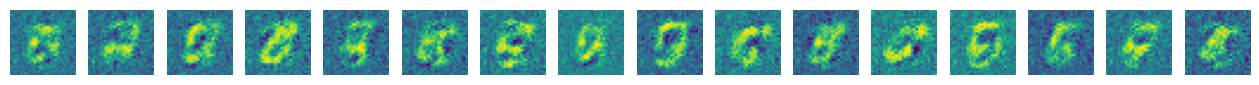

2024-11-05 13:33:28 | Batch 0/469 | d_loss: 0.2061 | g_loss: 4.8304 | D(x): 0.9488 | D(G(z)): 0.0505/0.0461
2024-11-05 13:33:29 | Batch 100/469 | d_loss: 0.1516 | g_loss: 5.9850 | D(x): 0.9556 | D(G(z)): 0.0356/0.0235
2024-11-05 13:33:30 | Batch 200/469 | d_loss: 0.1038 | g_loss: 5.7317 | D(x): 0.9493 | D(G(z)): 0.0097/0.0153
2024-11-05 13:33:31 | Batch 300/469 | d_loss: 0.0443 | g_loss: 5.8864 | D(x): 0.9874 | D(G(z)): 0.0248/0.0160
2024-11-05 13:33:32 | Batch 400/469 | d_loss: 0.0828 | g_loss: 6.4297 | D(x): 0.9821 | D(G(z)): 0.0500/0.0130


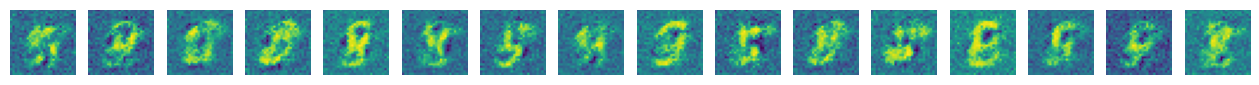

2024-11-05 13:33:34 | Batch 0/469 | d_loss: 0.2411 | g_loss: 6.3983 | D(x): 0.9128 | D(G(z)): 0.0056/0.0102
2024-11-05 13:33:35 | Batch 100/469 | d_loss: 0.0830 | g_loss: 5.8698 | D(x): 0.9670 | D(G(z)): 0.0155/0.0177
2024-11-05 13:33:36 | Batch 200/469 | d_loss: 0.0945 | g_loss: 5.4774 | D(x): 0.9715 | D(G(z)): 0.0368/0.0214
2024-11-05 13:33:37 | Batch 300/469 | d_loss: 0.1614 | g_loss: 4.2776 | D(x): 0.9444 | D(G(z)): 0.0222/0.0433
2024-11-05 13:33:37 | Batch 400/469 | d_loss: 0.0651 | g_loss: 5.5630 | D(x): 0.9667 | D(G(z)): 0.0111/0.0223


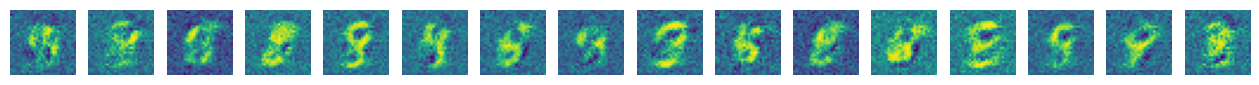

2024-11-05 13:33:40 | Batch 0/469 | d_loss: 0.1302 | g_loss: 6.8475 | D(x): 0.9854 | D(G(z)): 0.0776/0.0046
2024-11-05 13:33:41 | Batch 100/469 | d_loss: 0.0806 | g_loss: 5.3129 | D(x): 0.9834 | D(G(z)): 0.0525/0.0255
2024-11-05 13:33:42 | Batch 200/469 | d_loss: 0.0902 | g_loss: 5.5107 | D(x): 0.9774 | D(G(z)): 0.0383/0.0142
2024-11-05 13:33:42 | Batch 300/469 | d_loss: 0.0722 | g_loss: 5.5544 | D(x): 0.9713 | D(G(z)): 0.0266/0.0241
2024-11-05 13:33:43 | Batch 400/469 | d_loss: 0.0927 | g_loss: 5.2367 | D(x): 0.9695 | D(G(z)): 0.0284/0.0232


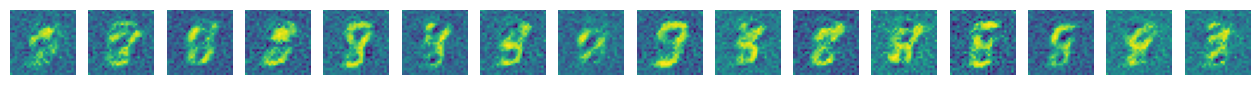

2024-11-05 13:33:46 | Batch 0/469 | d_loss: 0.0821 | g_loss: 5.2647 | D(x): 0.9699 | D(G(z)): 0.0239/0.0137
2024-11-05 13:33:46 | Batch 100/469 | d_loss: 0.0406 | g_loss: 4.6626 | D(x): 0.9789 | D(G(z)): 0.0138/0.0388
2024-11-05 13:33:47 | Batch 200/469 | d_loss: 0.0267 | g_loss: 5.6518 | D(x): 0.9900 | D(G(z)): 0.0153/0.0153
2024-11-05 13:33:48 | Batch 300/469 | d_loss: 0.0652 | g_loss: 6.4060 | D(x): 0.9818 | D(G(z)): 0.0236/0.0250
2024-11-05 13:33:49 | Batch 400/469 | d_loss: 0.0764 | g_loss: 6.0887 | D(x): 0.9821 | D(G(z)): 0.0283/0.0185


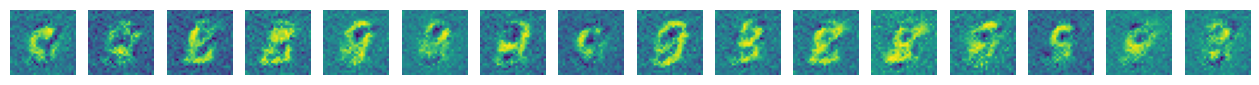

2024-11-05 13:33:51 | Batch 0/469 | d_loss: 0.0888 | g_loss: 5.6497 | D(x): 0.9699 | D(G(z)): 0.0298/0.0189
2024-11-05 13:33:52 | Batch 100/469 | d_loss: 0.1393 | g_loss: 6.8496 | D(x): 0.9725 | D(G(z)): 0.0388/0.0147
2024-11-05 13:33:53 | Batch 200/469 | d_loss: 0.0792 | g_loss: 6.3679 | D(x): 0.9749 | D(G(z)): 0.0246/0.0096
2024-11-05 13:33:55 | Batch 300/469 | d_loss: 0.1866 | g_loss: 5.0851 | D(x): 0.9536 | D(G(z)): 0.0239/0.0368
2024-11-05 13:33:55 | Batch 400/469 | d_loss: 0.2001 | g_loss: 5.3879 | D(x): 0.9478 | D(G(z)): 0.0235/0.0203


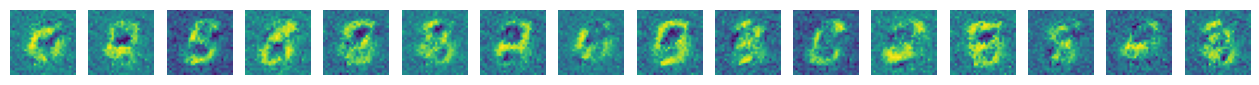

2024-11-05 13:33:58 | Batch 0/469 | d_loss: 0.2722 | g_loss: 6.9980 | D(x): 0.9660 | D(G(z)): 0.1058/0.0064
2024-11-05 13:33:59 | Batch 100/469 | d_loss: 0.0518 | g_loss: 6.7342 | D(x): 0.9988 | D(G(z)): 0.0405/0.0078
2024-11-05 13:34:00 | Batch 200/469 | d_loss: 0.0395 | g_loss: 5.7146 | D(x): 0.9809 | D(G(z)): 0.0107/0.0196
2024-11-05 13:34:00 | Batch 300/469 | d_loss: 0.0716 | g_loss: 6.3563 | D(x): 0.9890 | D(G(z)): 0.0311/0.0106
2024-11-05 13:34:01 | Batch 400/469 | d_loss: 0.1485 | g_loss: 5.2034 | D(x): 0.9456 | D(G(z)): 0.0236/0.0560


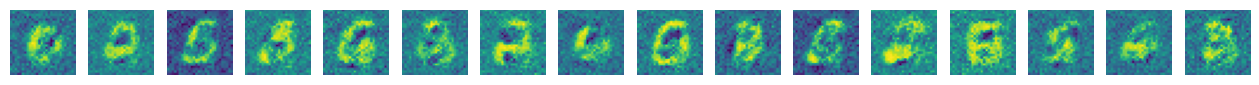

2024-11-05 13:34:03 | Batch 0/469 | d_loss: 0.0873 | g_loss: 5.4149 | D(x): 0.9609 | D(G(z)): 0.0256/0.0387
2024-11-05 13:34:04 | Batch 100/469 | d_loss: 0.1232 | g_loss: 5.0651 | D(x): 0.9538 | D(G(z)): 0.0190/0.0420
2024-11-05 13:34:05 | Batch 200/469 | d_loss: 0.0815 | g_loss: 7.5290 | D(x): 0.9639 | D(G(z)): 0.0104/0.0080
2024-11-05 13:34:06 | Batch 300/469 | d_loss: 0.2308 | g_loss: 4.8248 | D(x): 0.9309 | D(G(z)): 0.0419/0.0408
2024-11-05 13:34:07 | Batch 400/469 | d_loss: 0.1391 | g_loss: 5.4157 | D(x): 0.9640 | D(G(z)): 0.0466/0.0236


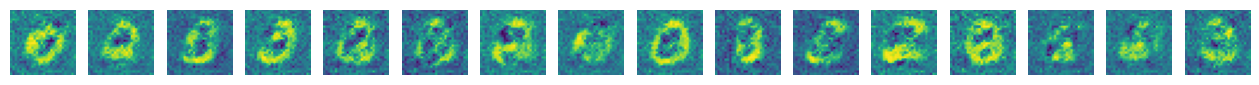

2024-11-05 13:34:09 | Batch 0/469 | d_loss: 0.1006 | g_loss: 6.2048 | D(x): 0.9837 | D(G(z)): 0.0474/0.0342
2024-11-05 13:34:10 | Batch 100/469 | d_loss: 0.0838 | g_loss: 5.2388 | D(x): 0.9683 | D(G(z)): 0.0238/0.0384
2024-11-05 13:34:11 | Batch 200/469 | d_loss: 0.1613 | g_loss: 6.3419 | D(x): 0.9742 | D(G(z)): 0.0699/0.0120
2024-11-05 13:34:12 | Batch 300/469 | d_loss: 0.1207 | g_loss: 5.7299 | D(x): 0.9589 | D(G(z)): 0.0345/0.0254
2024-11-05 13:34:13 | Batch 400/469 | d_loss: 0.1489 | g_loss: 4.8535 | D(x): 0.9564 | D(G(z)): 0.0400/0.0642


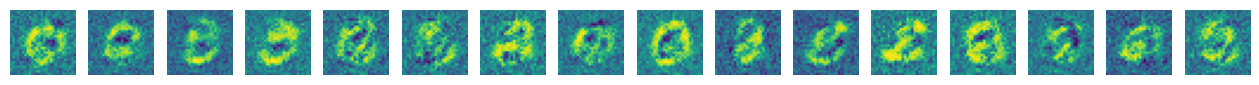

2024-11-05 13:34:15 | Batch 0/469 | d_loss: 0.0582 | g_loss: 6.6625 | D(x): 0.9810 | D(G(z)): 0.0236/0.0190
2024-11-05 13:34:16 | Batch 100/469 | d_loss: 0.1770 | g_loss: 5.9479 | D(x): 0.9755 | D(G(z)): 0.0508/0.0196
2024-11-05 13:34:17 | Batch 200/469 | d_loss: 0.0928 | g_loss: 5.8427 | D(x): 0.9649 | D(G(z)): 0.0344/0.0181
2024-11-05 13:34:18 | Batch 300/469 | d_loss: 0.1110 | g_loss: 5.9034 | D(x): 0.9540 | D(G(z)): 0.0226/0.0213
2024-11-05 13:34:19 | Batch 400/469 | d_loss: 0.0889 | g_loss: 5.5795 | D(x): 0.9766 | D(G(z)): 0.0307/0.0198


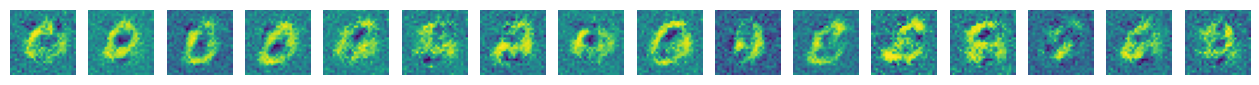

In [16]:
# Train the model for a few epochs
trainer.train(
    num_epochs=num_epochs,
    smooth=smooth,
    view_samples=True,
    g_updates=g_updates,
    label_noise=label_noise,
    instance_noise=instance_noise,
)

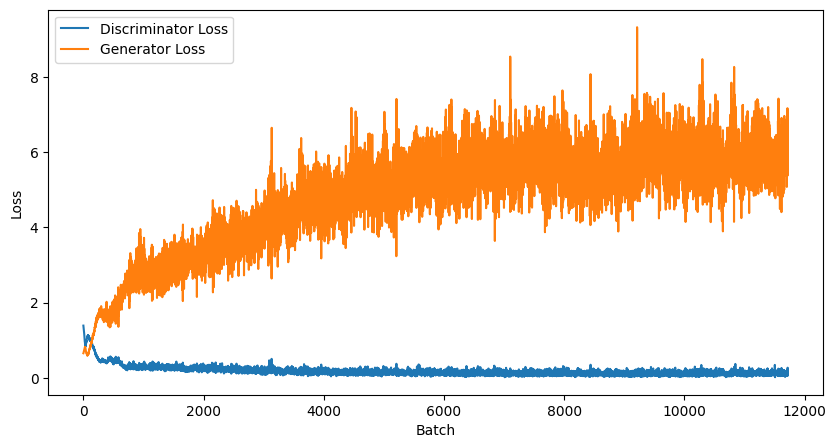

In [17]:
# Plot the trainer metrics
trainer.plot_metrics()

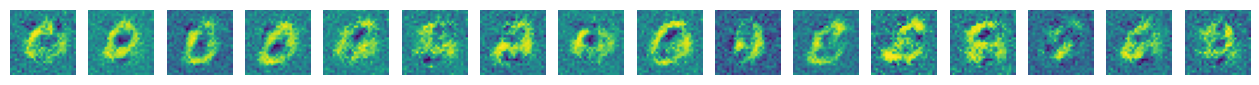

In [18]:
# Visualizing the final samples
trainer.view_samples(-1)